# Training public data

code written by following this github: https://github.com/ni79ls/har-keras-cnn

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import math

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D, LSTM, Embedding, SimpleRNN, GRU
from keras.utils import np_utils
from tensorflow.keras import optimizers

import warnings
warnings.filterwarnings('ignore')

In [86]:
data = pd.read_csv("Sisfall_dataset/processed_data.csv")

data

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,activity,mapped_activity,broad_mapped_activity
0,0.066,-0.699,-0.387,-1.099,-30.762,-21.484,SA01,D01,Walking,Walking
1,-0.195,-1.395,-0.027,-10.864,-46.753,-3.174,SA01,D01,Walking,Walking
2,0.336,-0.891,-0.246,31.860,-22.217,8.057,SA01,D01,Walking,Walking
3,0.273,-1.000,-0.062,2.625,-11.353,29.053,SA01,D01,Walking,Walking
4,0.047,-0.828,-0.074,7.263,15.869,26.184,SA01,D01,Walking,Walking
...,...,...,...,...,...,...,...,...,...,...
412897,0.988,-0.066,-0.023,26.917,-10.498,-15.625,SA21,F12,Lateral fall,Fall
412898,1.031,0.066,0.203,-14.954,16.235,26.184,SA21,F12,Lateral fall,Fall
412899,0.941,-0.188,0.359,-25.879,32.410,11.841,SA21,F12,Lateral fall,Fall
412900,0.859,-0.102,0.375,12.451,37.842,-2.136,SA21,F12,Lateral fall,Fall


In [87]:
data = data[data['activity']!="D18"]
data = data[data['activity']!="D19"]

In [11]:
# All data collected in 20Hz sample rate.

# Set display upto 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Labels are all the activity groups
LABELS = list(data.groupby(["broad_mapped_activity"]).groups.keys())

no_of_features = 6

# The number of steps within one time segment (window size)
TIME_PERIODS = 60
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 15

LABELS

['Fall',
 'Gentle jump',
 'Jogging',
 'Sitting action',
 'Stumble',
 'Walking',
 'climbing stairs',
 'getting up']

In [89]:
# split the data into training and test set
Training_data = data[~data["user"].isin(['SA17', 'SA18', 'SA19', 'SA20', 'SA21'])]
print(Training_data.shape)
Test_data = data[data["user"].isin(['SA17', 'SA18', 'SA19', 'SA20', 'SA21'])]
Test_data

(262802, 10)


,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,activity,mapped_activity,broad_mapped_activity
16000,0.168,-0.918,-0.219,-0.488,5.127,-13.367,SA17,D01,Walking,Walking
16001,0.121,-0.906,-0.207,-4.211,6.775,-4.517,SA17,D01,Walking,Walking
16002,0.109,-0.953,-0.160,-9.766,2.808,0.854,SA17,D01,Walking,Walking
16003,0.113,-0.965,-0.184,-7.080,-6.897,5.798,SA17,D01,Walking,Walking
16004,0.129,-0.980,-0.168,-4.333,-14.709,5.005,SA17,D01,Walking,Walking
...,...,...,...,...,...,...,...,...,...,...
412897,0.988,-0.066,-0.023,26.917,-10.498,-15.625,SA21,F12,Lateral fall,Fall
412898,1.031,0.066,0.203,-14.954,16.235,26.184,SA21,F12,Lateral fall,Fall
412899,0.941,-0.188,0.359,-25.879,32.410,11.841,SA21,F12,Lateral fall,Fall
412900,0.859,-0.102,0.375,12.451,37.842,-2.136,SA21,F12,Lateral fall,Fall


In [90]:
# Encode labels
le = preprocessing.LabelEncoder()
Training_data['encoded_label'] = le.fit_transform(Training_data['broad_mapped_activity'].values.ravel())
print(list(le.classes_))

['Fall', 'Jogging', 'Sitting action', 'Walking', 'climbing stairs', 'getting up']


In [91]:
def normalize_features(data, mu, sigma):
    print("mean: ", mu)
    print("standard deviation: ", sigma)
    return (data - mu)/sigma
#     maxim = np.max(data, axis=0)
#     minim = np.min(data, axis=0)
#     return (data - minim)/(maxim - minim)

In [92]:
mu = []
sigma = []
for i in range(0,6):
    print(Training_data.columns[i])
    mu.append(np.mean(Training_data.iloc[:, i], axis=0))
    sigma.append(np.std(Training_data.iloc[:, i], axis=0))
    Training_data.iloc[:, i] = normalize_features(Training_data.iloc[:, i], mu[i], sigma[i])
    
Training_data

accel_x
mean:  0.012236175547560521
standard deviation:  0.34769250871819196
accel_y
mean:  -0.844028325626327
standard deviation:  0.5536567307930977
accel_z
mean:  -0.1543912455955434
standard deviation:  0.42467598155613845
gyro_x
mean:  0.2556826382272823
standard deviation:  35.02454787273533
gyro_y
mean:  1.5261069734771806
standard deviation:  35.0604674029397
gyro_z
mean:  -0.2920010667935128
standard deviation:  27.524737149885194


,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,user,activity,mapped_activity,broad_mapped_activity,encoded_label
0,0.156,0.262,-0.547,-0.039,-0.921,-0.770,SA01,D01,Walking,Walking,3
1,-0.597,-0.994,0.299,-0.317,-1.377,-0.105,SA01,D01,Walking,Walking,3
2,0.931,-0.084,-0.216,0.902,-0.677,0.303,SA01,D01,Walking,Walking,3
3,0.751,-0.282,0.216,0.068,-0.367,1.066,SA01,D01,Walking,Walking,3
4,0.100,0.029,0.189,0.200,0.409,0.962,SA01,D01,Walking,Walking,3
...,...,...,...,...,...,...,...,...,...,...,...
409897,2.796,1.793,-0.216,0.028,-0.099,-0.102,SA11,F12,Lateral fall,Fall,0
409898,2.774,1.856,-0.216,0.054,-0.063,-0.074,SA11,F12,Lateral fall,Fall,0
409899,2.807,1.821,-0.225,0.083,-0.028,-0.023,SA11,F12,Lateral fall,Fall,0
409900,2.751,1.835,-0.234,0.090,0.023,-0.005,SA11,F12,Lateral fall,Fall,0


In [3]:
def create_segments(data):

    segments = []
    labels = []
    for i in range(0, len(data) - TIME_PERIODS, STEP_DISTANCE):
        accel_xs = data['accel_x'].values[i: i + TIME_PERIODS]
        accel_ys = data['accel_y'].values[i: i + TIME_PERIODS]
        accel_zs = data['accel_z'].values[i: i + TIME_PERIODS]
        gyro_xs = data['gyro_x'].values[i: i + TIME_PERIODS]
        gyro_ys = data['gyro_y'].values[i: i + TIME_PERIODS]
        gyro_zs = data['gyro_z'].values[i: i + TIME_PERIODS]
#         mag_xs = data['mag_x'].values[i: i + TIME_PERIODS]
#         mag_ys = data['mag_y'].values[i: i + TIME_PERIODS]
#         mag_zs = data['mag_z'].values[i: i + TIME_PERIODS]
        
#         #Features
#         #mean
#         accel_x_mean = np.full(TIME_PERIODS, accel_xs.mean())
#     #     y_mean = np.full(TIME_PERIODS, ys.mean())
#         accel_z_mean = np.full(TIME_PERIODS, accel_zs.mean())
#         gyro_x_mean = np.full(TIME_PERIODS, gyro_xs.mean())
#     #     pitch_mean = np.full(TIME_PERIODS, pitchs.mean())
#         gyro_z_mean = np.full(TIME_PERIODS, gyro_zs.mean())
#         #standard deviation
#         accel_x_std = np.full(TIME_PERIODS, accel_xs.std())
#         accel_y_std = np.full(TIME_PERIODS, accel_ys.std())
#         accel_z_std = np.full(TIME_PERIODS, accel_zs.std())
#         gyro_x_std = np.full(TIME_PERIODS, gyro_xs.std())
#         gyro_y_std = np.full(TIME_PERIODS, gyro_ys.std())
#         gyro_z_std = np.full(TIME_PERIODS, gyro_zs.std())
#         #min
#         accel_x_min = np.full(TIME_PERIODS, accel_xs.min())
#         accel_y_min = np.full(TIME_PERIODS, accel_ys.min())
#         accel_z_min = np.full(TIME_PERIODS, accel_zs.min())
#         gyro_x_min = np.full(TIME_PERIODS, gyro_xs.min())
#     #     pitch_min = np.full(TIME_PERIODS, pitchs.min())
#     #     yaw_min = np.full(TIME_PERIODS, yaws.min())
    
#         #energy, here ** represents exponentiation
#         accel_x_eng = np.full(TIME_PERIODS, np.sum(accel_xs**2)/TIME_PERIODS) 
#         accel_y_eng = np.full(TIME_PERIODS, np.sum(accel_ys**2)/TIME_PERIODS)
#         accel_z_eng = np.full(TIME_PERIODS, np.sum(accel_zs**2)/TIME_PERIODS)
#         #median absolute deviation (MAD)
#         accel_x_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(accel_xs))
#     #     y_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(ys))
#         accel_z_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(accel_zs))
#     #     roll_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(rolls))
#         gyro_y_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(gyro_ys))
#         gyro_z_mad = np.full(TIME_PERIODS, stats.median_abs_deviation(gyro_zs))
#         # signal magnitude area
#         accel_sma = np.full(TIME_PERIODS, (np.sum(np.abs(accel_xs)) + np.sum(np.abs(accel_ys)) + np.sum(np.abs(accel_zs))) / TIME_PERIODS)
#         gyro_sma = np.full(TIME_PERIODS, (np.sum(np.abs(gyro_xs)) + np.sum(np.abs(gyro_ys)) + np.sum(np.abs(gyro_zs))) / TIME_PERIODS)
# #         # get frequency domain signal
# #         x_freq = np.abs(np.fft.fft(xs))[1:51]
# #         y_freq = np.abs(np.fft.fft(ys))[1:51]
# #         z_freq = np.abs(np.fft.fft(zs))[1:51]
# #         roll_freq = np.abs(np.fft.fft(rolls))[1:51]
# #         pitch_freq = np.abs(np.fft.fft(pitchs))[1:51]
# #         yaw_freq = np.abs(np.fft.fft(yaws))[1:51]
# #         # freq mean
# #         x_freq_mean = np.full(TIME_PERIODS, x_freq.mean())
# #         y_freq_mean = np.full(TIME_PERIODS, y_freq.mean())
# #         z_freq_mean = np.full(TIME_PERIODS, z_freq.mean())
# #         roll_freq_mean = np.full(TIME_PERIODS, roll_freq.mean())
# #         pitch_freq_mean = np.full(TIME_PERIODS, pitch_freq.mean())
# #         yaw_freq_mean = np.full(TIME_PERIODS, yaw_freq.mean())
# #         #freq standard deviation
# #         x_freq_std = np.full(TIME_PERIODS, x_freq.std())
# #         y_freq_std = np.full(TIME_PERIODS, y_freq.std())
# #         z_freq_std = np.full(TIME_PERIODS, z_freq.std())
# #         roll_freq_std = np.full(TIME_PERIODS, roll_freq.std())
# #         pitch_freq_std = np.full(TIME_PERIODS, pitch_freq.std())
# #         yaw_freq_std = np.full(TIME_PERIODS, yaw_freq.std())

        # Retrieve the most often used label in this segment
        label = stats.mode(data['encoded_label'][i: i + TIME_PERIODS])[0][0]
        
#         segments.append([accel_xs, accel_ys, accel_zs, gyro_xs, gyro_ys, gyro_zs, accel_x_mean,\
#                          accel_z_mean, gyro_x_mean, gyro_z_mean, accel_x_std, accel_y_std, accel_z_std, gyro_x_std,  gyro_y_std, \
#                          gyro_z_std, accel_x_min, accel_y_min, accel_z_min, gyro_x_min, accel_x_eng, accel_y_eng, accel_z_eng, \
#                          accel_x_mad, accel_z_mad, gyro_y_mad, gyro_z_mad, accel_sma, gyro_sma])
        segments.append([accel_xs, accel_ys, accel_zs, gyro_xs, gyro_ys, gyro_zs])
        labels.append(label)

    # Bring the segments into a better shape
    x_data = np.asarray(segments, dtype= np.float32).reshape(-1, TIME_PERIODS, no_of_features)
    y_data = np.asarray(labels)
    return x_data, y_data


In [94]:
x_train, y_train = create_segments(Training_data)
np.set_printoptions(threshold=np.inf)
print("x shape: ",x_train.shape)
print("y shape: ",y_train.shape)

x shape:  (17517, 60, 6)
y shape:  (17517,)


In [95]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS*no_of_features)
x_train.shape

(17517, 360)

In [96]:
# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

# One-hot encoding of y_train labels (only execute once!)
y_train = np_utils.to_categorical(y_train, len(LABELS))
print('New y_train shape: ', y_train.shape)

New y_train shape:  (17517, 6)


### 1D-CNN Model

In [13]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS,no_of_features), input_shape=(TIME_PERIODS*no_of_features,)))
model_m.add(Conv1D(100, 3, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(120, 3, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(80, 3, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.3))
model_m.add(Dense(len(LABELS), activation='softmax'))
print(model_m.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 60, 6)             0         
                                                                 
 conv1d (Conv1D)             (None, 58, 100)           1900      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 100)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 120)           36120     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 120)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 80)             2

In [14]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
]

opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

model_m.compile(loss='categorical_crossentropy',
                optimizer=opt, metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
88/88 [==============================] - 4s 18ms/step - loss: 1.3027 - accuracy: 0.5355
Epoch 2/50
88/88 [==============================] - 1s 13ms/step - loss: 0.8421 - accuracy: 0.7034
Epoch 3/50
88/88 [==============================] - 1s 13ms/step - loss: 0.7311 - accuracy: 0.7391
Epoch 4/50
88/88 [==============================] - 1s 13ms/step - loss: 0.6622 - accuracy: 0.7609
Epoch 5/50
88/88 [==============================] - 1s 14ms/step - loss: 0.6180 - accuracy: 0.7772
Epoch 6/50
88/88 [==============================] - 1s 14ms/step - loss: 0.5835 - accuracy: 0.7919
Epoch 7/50
88/88 [==============================] - 1s 13ms/step - loss: 0.5517 - accuracy: 0.8020
Epoch 8/50
88/88 [==============================] - 1s 13ms/step - loss: 0.5412 - accuracy: 0.8061
Epoch 9/50
88/88 [==============================] - 1s 13ms/step - loss: 0.5137 - accuracy: 0.8159
Epoch 10/50
88/88 [==============================] - 1s 13ms/step - loss: 0.4951 - accuracy: 0.8211
Epoch 11/

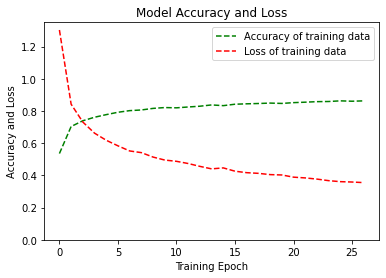

In [15]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [97]:
# Set input_shape / reshape for Keras
# Encode labels
Test_data['encoded_label'] = le.transform(Test_data['broad_mapped_activity'].values.ravel())
print(list(le.classes_))

for i in range(0,6):
    print(data.columns[i])
    Test_data.iloc[:, i] = normalize_features(Test_data.iloc[:, i], mu[i], sigma[i])
    
x_test, y_test = create_segments(Test_data)
print("x shape: ",x_test.shape)
print("y shape: ",y_test.shape)

x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS*no_of_features)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, len(LABELS))
y_test.shape

['Fall', 'Jogging', 'Sitting action', 'Walking', 'climbing stairs', 'getting up']
accel_x
mean:  0.012236175547560521
standard deviation:  0.34769250871819196
accel_y
mean:  -0.844028325626327
standard deviation:  0.5536567307930977
accel_z
mean:  -0.1543912455955434
standard deviation:  0.42467598155613845
gyro_x
mean:  0.2556826382272823
standard deviation:  35.02454787273533
gyro_y
mean:  1.5261069734771806
standard deviation:  35.0604674029397
gyro_z
mean:  -0.2920010667935128
standard deviation:  27.524737149885194
x shape:  (8723, 60, 6)
y shape:  (8723,)


(8723, 6)

In [17]:
score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

273/273 [==============================] - 2s 4ms/step - loss: 0.4633 - accuracy: 0.8251

Accuracy on test data: 0.83

Loss on test data: 0.46


In [98]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

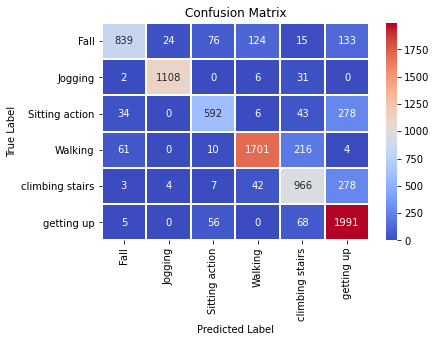


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.89      0.69      0.78      1211
           1       0.98      0.97      0.97      1147
           2       0.80      0.62      0.70       953
           3       0.91      0.85      0.88      1992
           4       0.72      0.74      0.73      1300
           5       0.74      0.94      0.83      2120

    accuracy                           0.83      8723
   macro avg       0.84      0.80      0.81      8723
weighted avg       0.83      0.83      0.82      8723



In [19]:
y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [20]:
model_m.save('best_model_cnn.h5')

### LSTM Model

In [54]:
model_lstm = Sequential()
model_lstm.add(LSTM(200, input_shape=(TIME_PERIODS,no_of_features)))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(100, activation='relu'))
model_lstm.add(Dense(len(LABELS), activation='softmax'))
print(model_lstm.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 200)               165600    
                                                                 
 dropout_6 (Dropout)         (None, 200)               0         
                                                                 
 dense_12 (Dense)            (None, 100)               20100     
                                                                 
 dense_13 (Dense)            (None, 6)                 606       
                                                                 
Total params: 186,306
Trainable params: 186,306
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS, no_of_features)
x_train.shape

(17517, 60, 6)

In [56]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
]

opt = optimizers.Adam(learning_rate=0.001)

model_lstm.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_lstm.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
88/88 [==============================] - 6s 43ms/step - loss: 0.4438 - accuracy: 0.2925
Epoch 2/50
88/88 [==============================] - 4s 42ms/step - loss: 0.3451 - accuracy: 0.4948
Epoch 3/50
88/88 [==============================] - 4s 43ms/step - loss: 0.2717 - accuracy: 0.6438
Epoch 4/50
88/88 [==============================] - 4s 43ms/step - loss: 0.2163 - accuracy: 0.7290
Epoch 5/50
88/88 [==============================] - 4s 43ms/step - loss: 0.1918 - accuracy: 0.7633
Epoch 6/50
88/88 [==============================] - 4s 43ms/step - loss: 0.1703 - accuracy: 0.7896
Epoch 7/50
88/88 [==============================] - 4s 43ms/step - loss: 0.1581 - accuracy: 0.8073
Epoch 8/50
88/88 [==============================] - 4s 43ms/step - loss: 0.1462 - accuracy: 0.8181
Epoch 9/50
88/88 [==============================] - 4s 43ms/step - loss: 0.1388 - accuracy: 0.8274
Epoch 10/50
88/88 [==============================] - 4s 43ms/step - loss: 0.1288 - accuracy: 0.8395
Epoch 11/

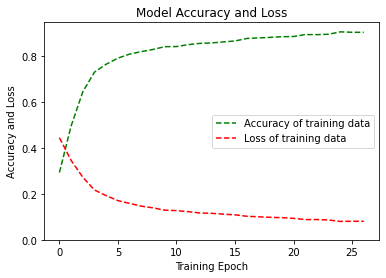

In [57]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [58]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS, no_of_features)
x_test.shape

(8723, 60, 6)

In [59]:
score = model_lstm.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

273/273 [==============================] - 2s 7ms/step - loss: 0.1979 - accuracy: 0.7965

Accuracy on test data: 0.80

Loss on test data: 0.20


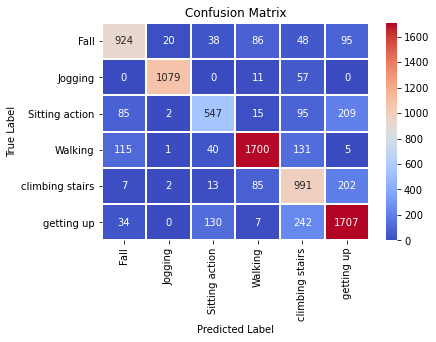


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.79      0.76      0.78      1211
           1       0.98      0.94      0.96      1147
           2       0.71      0.57      0.64       953
           3       0.89      0.85      0.87      1992
           4       0.63      0.76      0.69      1300
           5       0.77      0.81      0.79      2120

    accuracy                           0.80      8723
   macro avg       0.80      0.78      0.79      8723
weighted avg       0.80      0.80      0.80      8723



In [60]:
y_pred_test = model_lstm.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [61]:
model_lstm.save('best_model_lstm.h5')

### 1D CNN + LSTM Model

In [116]:
model_lsnet = Sequential()
model_lsnet.add(Conv1D(100, 3, activation='relu', input_shape=(TIME_PERIODS,no_of_features)))
model_lsnet.add(LSTM(200, return_sequences=True))
model_lsnet.add(Conv1D(100, 3, activation='relu'))
model_lsnet.add(MaxPooling1D(3))
model_lsnet.add(Conv1D(80, 3, activation='relu'))
model_lsnet.add(GlobalAveragePooling1D())
model_lsnet.add(Dropout(0.4))
model_lsnet.add(Dense(100, activation='relu'))
model_lsnet.add(Dense(len(LABELS), activation='softmax'))
print(model_lsnet.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 58, 100)           1900      
                                                                 
 lstm_12 (LSTM)              (None, 58, 200)           240800    
                                                                 
 conv1d_11 (Conv1D)          (None, 56, 100)           60100     
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 18, 100)          0         
 1D)                                                             
                                                                 
 conv1d_12 (Conv1D)          (None, 16, 80)            24080     
                                                                 
 global_average_pooling1d_2   (None, 80)               0         
 (GlobalAveragePooling1D)                            

In [117]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS, no_of_features)
x_train.shape

(17517, 60, 6)

In [118]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)
]

opt = optimizers.Adam(learning_rate=0.001)

model_lsnet.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_lsnet.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
88/88 [==============================] - 12s 84ms/step - loss: 0.3686 - accuracy: 0.4852
Epoch 2/50
88/88 [==============================] - 7s 78ms/step - loss: 0.2576 - accuracy: 0.6694
Epoch 3/50
88/88 [==============================] - 7s 79ms/step - loss: 0.2257 - accuracy: 0.7180
Epoch 4/50
88/88 [==============================] - 20s 228ms/step - loss: 0.1970 - accuracy: 0.7651
Epoch 5/50
88/88 [==============================] - 18s 199ms/step - loss: 0.1761 - accuracy: 0.7869
Epoch 6/50
88/88 [==============================] - 17s 196ms/step - loss: 0.1560 - accuracy: 0.8078
Epoch 7/50
88/88 [==============================] - 17s 193ms/step - loss: 0.1446 - accuracy: 0.8257
Epoch 8/50
88/88 [==============================] - 17s 193ms/step - loss: 0.1375 - accuracy: 0.8318
Epoch 9/50
88/88 [==============================] - 17s 195ms/step - loss: 0.1297 - accuracy: 0.8411
Epoch 10/50
88/88 [==============================] - 22s 249ms/step - loss: 0.1246 - accuracy: 0

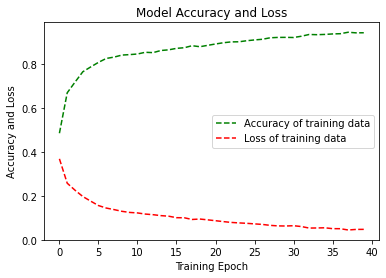

In [119]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [120]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS, no_of_features)
x_test.shape

(8723, 60, 6)

In [121]:
score = model_lsnet.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

273/273 [==============================] - 6s 17ms/step - loss: 0.1966 - accuracy: 0.8278

Accuracy on test data: 0.83

Loss on test data: 0.20


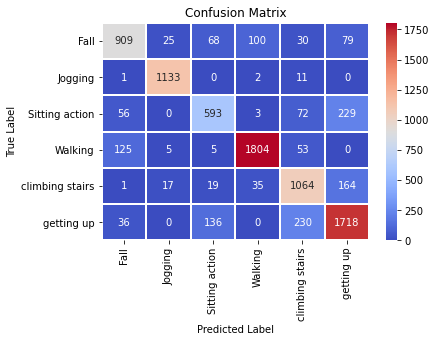


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1211
           1       0.96      0.99      0.97      1147
           2       0.72      0.62      0.67       953
           3       0.93      0.91      0.92      1992
           4       0.73      0.82      0.77      1300
           5       0.78      0.81      0.80      2120

    accuracy                           0.83      8723
   macro avg       0.82      0.82      0.82      8723
weighted avg       0.83      0.83      0.83      8723



In [122]:
y_pred_test = model_lsnet.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

In [123]:
model_lsnet.save('best_model_lsnet.h5')

### RNN Model

In [79]:
model_rnn = keras.Sequential()
model_rnn.add(Embedding(input_dim=TIME_PERIODS*no_of_features, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model_rnn.add(GRU(128, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model_rnn.add(SimpleRNN(64))
model_rnn.add(Dropout(0.4))
model_rnn.add(Dense(len(LABELS), activation='softmax'))

model_rnn.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 64)          23040     
                                                                 
 gru_5 (GRU)                 (None, None, 128)         74496     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 6)                 390       
                                                                 
Total params: 110,278
Trainable params: 110,278
Non-trainable params: 0
_________________________________________________________________


In [80]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIODS*no_of_features)
x_train.shape

(17517, 360)

In [82]:
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

# opt = optimizers.SGD(learning_rate=0.01, momentum=0.9)

model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 50

history = model_rnn.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      verbose=1)

Epoch 1/50
88/88 [==============================] - 154s 2s/step - loss: 1.5750 - accuracy: 0.3740
Epoch 2/50
88/88 [==============================] - 144s 2s/step - loss: 1.4819 - accuracy: 0.4450
Epoch 3/50
88/88 [==============================] - 151s 2s/step - loss: 1.4235 - accuracy: 0.4675
Epoch 4/50
88/88 [==============================] - 155s 2s/step - loss: 1.3584 - accuracy: 0.4896
Epoch 5/50
88/88 [==============================] - 155s 2s/step - loss: 1.3501 - accuracy: 0.4891


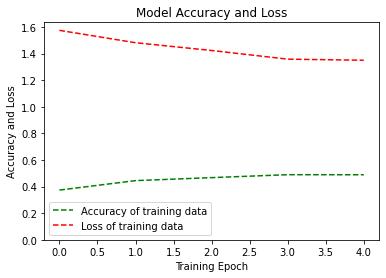

In [83]:
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
# plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
# plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [106]:
x_test = x_test.reshape(x_test.shape[0], TIME_PERIODS*no_of_features)
x_test.shape

(8723, 360)

In [107]:
score = model_rnn.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

273/273 [==============================] - 28s 99ms/step - loss: 1.2816 - accuracy: 0.5012

Accuracy on test data: 0.50

Loss on test data: 1.28


In [110]:
y_pred_test = model_rnn.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))

# Making Predictions

In [32]:
data = pd.read_csv("Sisfall_dataset/processed_data.csv")
data = data[data['activity']!="D18"]
data = data[data['activity']!="D19"]

Test_data = data[data["user"].isin(['SA17', 'SA18', 'SA19', 'SA20', 'SA21'])]

activity = {'Fall': 0, 'Jogging': 1, 'Sitting action': 2, 'Walking': 3, 'climbing stairs': 4, 'getting up': 5}
le = preprocessing.LabelEncoder()
Test_data['encoded_label'] = le.fit_transform(Test_data['broad_mapped_activity'].values.ravel())
print(le.classes_)

mu = [0.012236175547560521, -0.844028325626327, -0.1543912455955434, 0.2556826382272823, 1.5261069734771806, -0.2920010667935128]
sigma = [0.34769250871819196, 0.5536567307930977, 0.42467598155613845, 35.02454787273533, 35.0604674029397, 27.524737149885194]

def normalize_features(data, mu_data, sigma_data):
    return (data - mu_data)/sigma_data

for i in range(0,6):
        Test_data.iloc[:, i] = normalize_features(Test_data.iloc[:, i], mu[i], sigma[i])
        
Test_data = Test_data[100000:105000]
print(Test_data)

x_test_data, y_test_labels = create_segments(Test_data)
print("test data shape: ", x_test_data.shape)

model = keras.models.load_model('best_model_lstm.h5')

x_test_data = x_test_data.astype("float32")

pred = model.predict(x_test_data)
prediction = np.argmax(pred, axis=1)
print("Predictions:", prediction)
print("Actual:", y_test_labels)

['Fall' 'Jogging' 'Sitting action' 'Walking' 'climbing stairs'
 'getting up']
        accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z  user activity  \
324002   -0.069   -0.126    0.106   0.214   0.393  -0.612  SA19      F03   
324003    0.111   -0.155    0.216  -0.119   0.762  -0.510  SA19      F03   
324004   -0.406   -0.324    0.483  -0.197   0.883  -0.102  SA19      F03   
324005   -0.833   -0.642    0.538   0.064   0.722  -0.034  SA19      F03   
324006   -0.912   -0.832    0.897   0.411   0.487   0.146  SA19      F03   
...         ...      ...      ...     ...     ...     ...   ...      ...   
336997   -0.878   -0.853   -0.372  -0.699   0.524   1.188  SA21      F04   
336998    0.852   -0.098   -0.676  -0.080   0.035   0.778  SA21      F04   
336999    0.279   -0.500   -0.290  -0.009   0.834   0.370  SA21      F04   
337000   -0.204   -0.035   -0.152   0.181   0.160  -0.227  SA21      F04   
337001   -0.024    0.184    0.023   0.001   0.007  -0.542  SA21      F04   

       ma